# Convolutional Sentiment Classifier

In this notebook, we build a *convolutional* neural net to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
# For the CNN: 1D convolutiona layer, 1D Dropout - avoid overfitting-, 1D Maxplloing -reduce the  Dim-  
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new! 

from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/conv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
# More power with CNN so increase the lenght to 400, without much time consumption
max_review_length = 400
pad_type = trunc_type = 'pre'
# Dropping 20% in the Embedding layer
drop_embed = 0.2 # new!

# convolutional layer architecture:
n_conv = 256 # filters, a.k.a. kernels
# In MNIST: squares 2*2, 4*4,....
#Here we will look for Squences of 1D*3: 3 words in a row that convey Positive or Negative Sentiment
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
#Reduced Because of the previous Droupout
dropout = 0.2

#### Load data

In [3]:
# removed n_words_to_skip; 
#Note: differing from the original expirement "Maas"; leaving the commun words improved the result
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) 

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
#The added Dropout 20%
model.add(SpatialDropout1D(drop_embed))
#No need for Flatten; The Conv layer takes care of getting the Dim of the matracess lined up
model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D()) # No specific kernel size; 
#"Global" will take as many values as available; in this case the difined 3
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary() 
#Fewer parameters than the Dense architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

#### Configure model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [10]:
# 89.1% validation accuracy in epoch 2
# ...with second convolutional layer is essentially the same at 89.0%
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 404s - loss: 0.4794 - acc: 0.7462 - val_loss: 0.2928 - val_acc: 0.8746
Epoch 2/4
25000/25000 [==============================] - 444s - loss: 0.2521 - acc: 0.8973 - val_loss: 0.2575 - val_acc: 0.8937
Epoch 3/4
25000/25000 [==============================] - 501s - loss: 0.1745 - acc: 0.9342 - val_loss: 0.2657 - val_acc: 0.8909
Epoch 4/4
25000/25000 [==============================] - 444s - loss: 0.1165 - acc: 0.9589 - val_loss: 0.3084 - val_acc: 0.8830


#### Evaluate

In [11]:
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [12]:
y_hat = model.predict_proba(x_valid)

24992/25000 [============================>.] - ETA: 0s

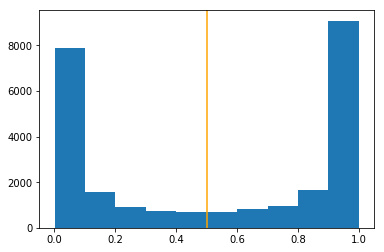

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.07'

In [15]:
# comparatif of individual results
# tranforming from nested lists to single list
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [17]:
import pandas as pd
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [18]:
ydf.head(10)

,y_hat,y
0,0.979829,1
1,0.991963,1
2,0.955357,1
3,0.468536,1
4,0.992930,1
5,0.205963,0
6,0.009892,0
7,0.013358,0
8,0.985240,1
9,0.794785,1


In [21]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
105,0.919188,0
204,0.924130,0
240,0.972928,0
341,0.973604,0
353,0.941621,0
419,0.952235,0
489,0.983549,0
534,0.958400,0
584,0.914026,0
822,0.939164,0
